# Imports

In [25]:
%load_ext autoreload
%autoreload 2

import math
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask

import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
#from memflow.ttH.tth import ttHRecoDataset,ttHHardDataset
from memflow.dataset.template_dataset import ttHHardDataset, ttHRecoDataset
from memflow.models.transfer_flow_model import TransferFlow
from memflow.models.custom_flows import *
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback, BiasCallback
import os

vector.register_awkward()

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  12836 KiB |  14171 KiB | 235615 KiB | 222778 KiB |
|---------------------------------------------------------------------------|
| Active memory         |  12836 KiB |  14171 KiB | 235615 KiB | 222778 KiB |
|---------------------------------------------------------------------------|
| Requested me

# Data

In [26]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    N = 500,
)

print (data_hard)

Data object
Loaded branches:
   ... file: 500
   ... sample: 500
   ... tree: 500
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi
   ... Z_fr

# Hard dataset

In [27]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        'higgs',
        'tops',
        'bottoms',
        'Ws',
        'Zs',
        'quarks',
        'neutrinos',
    ],
    build = True,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(hard_dataset)

Selecting 200 events out of 500
Before cut: 14 events
After cut: 200 events
Saving objects to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Parton dataset with 200 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
boost      : data ([200, 1, 4]), mask ([200, 1])
             Mask exist    : [100.00%]
             Mask attn     : [True]
             Weights       : 200.00
             Features      : ['x', 'y', 'z', 't']
             Selected for batches : False
higgs      : data ([200, 1, 5]), mask ([200, 1])
             Mask exist    : [100.00%]
             Mask at

Before preprocessing


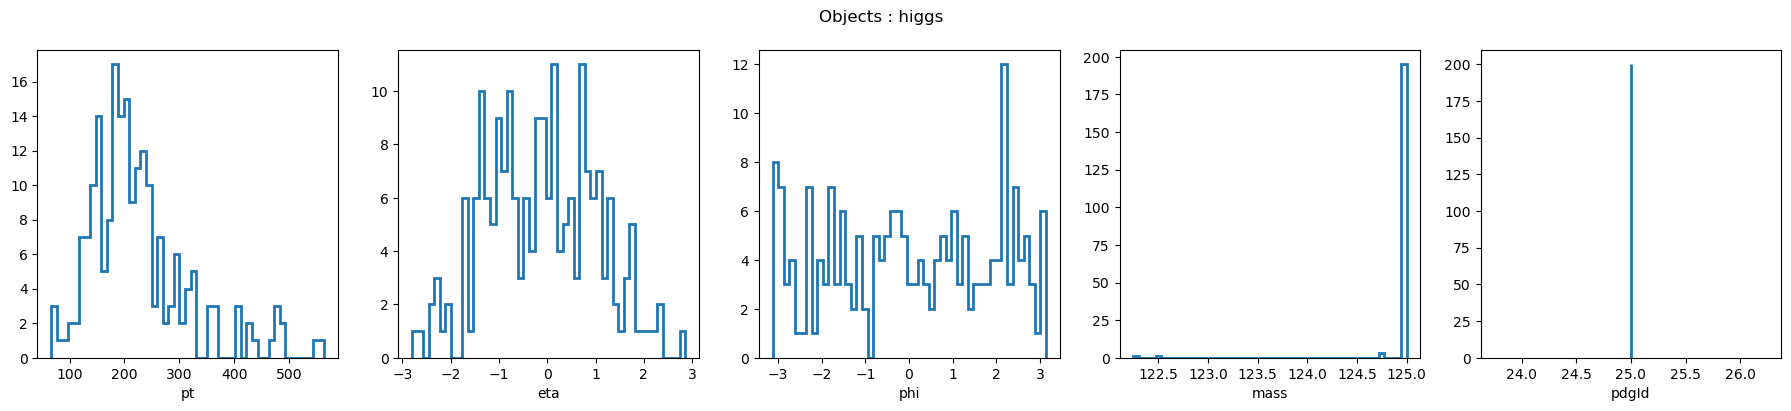

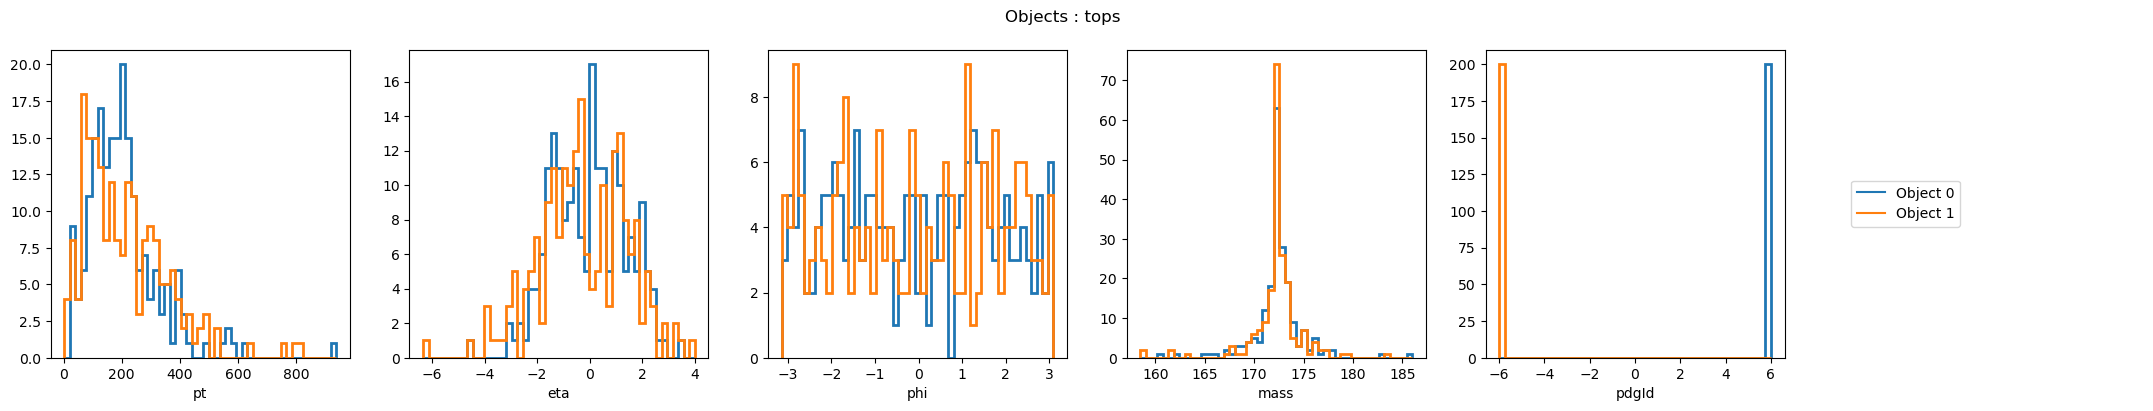

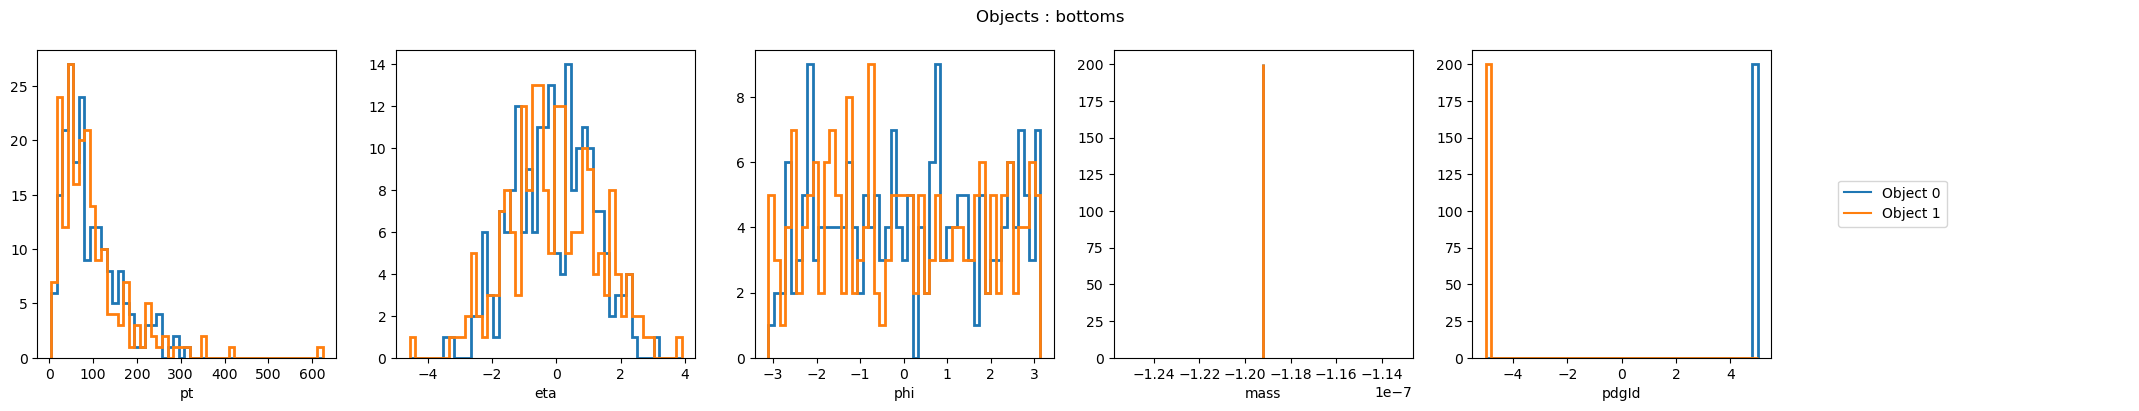

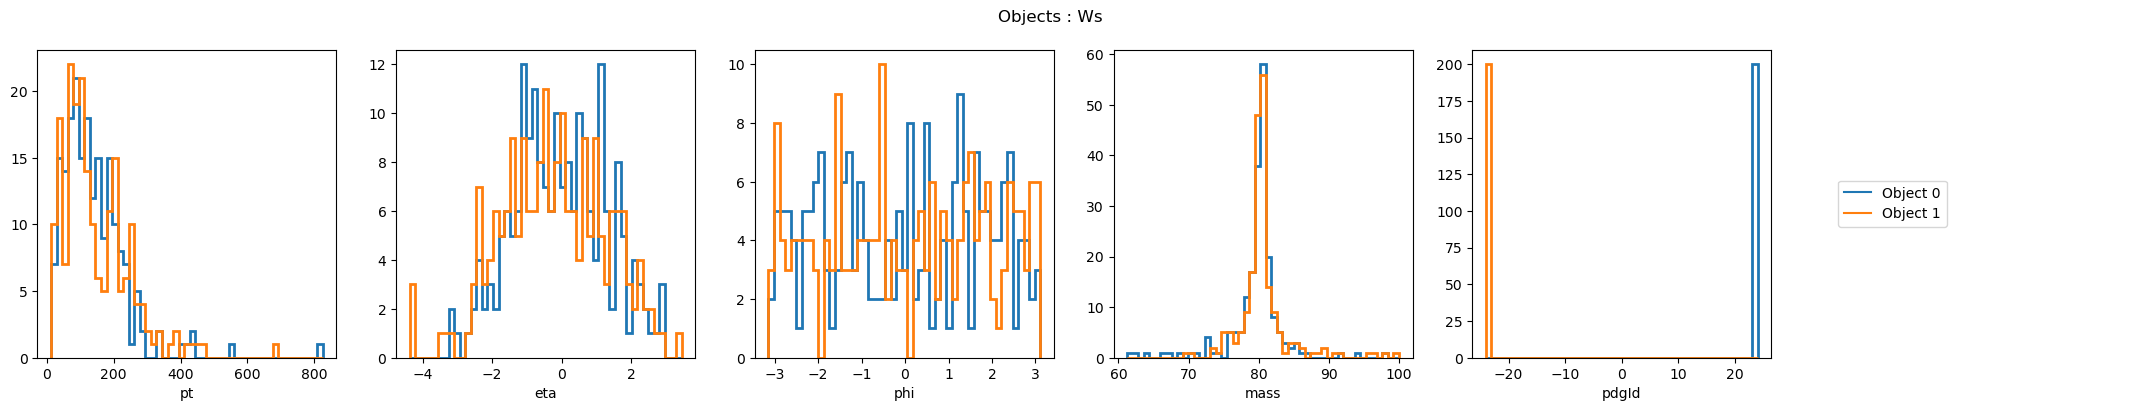

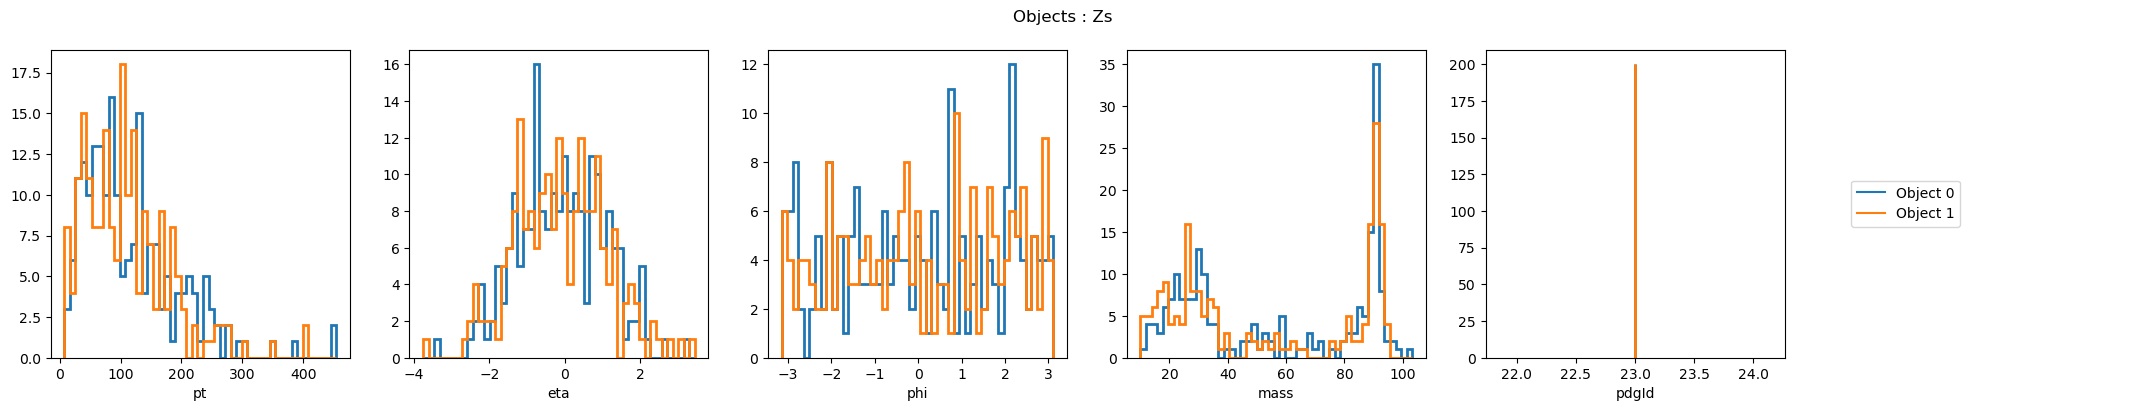

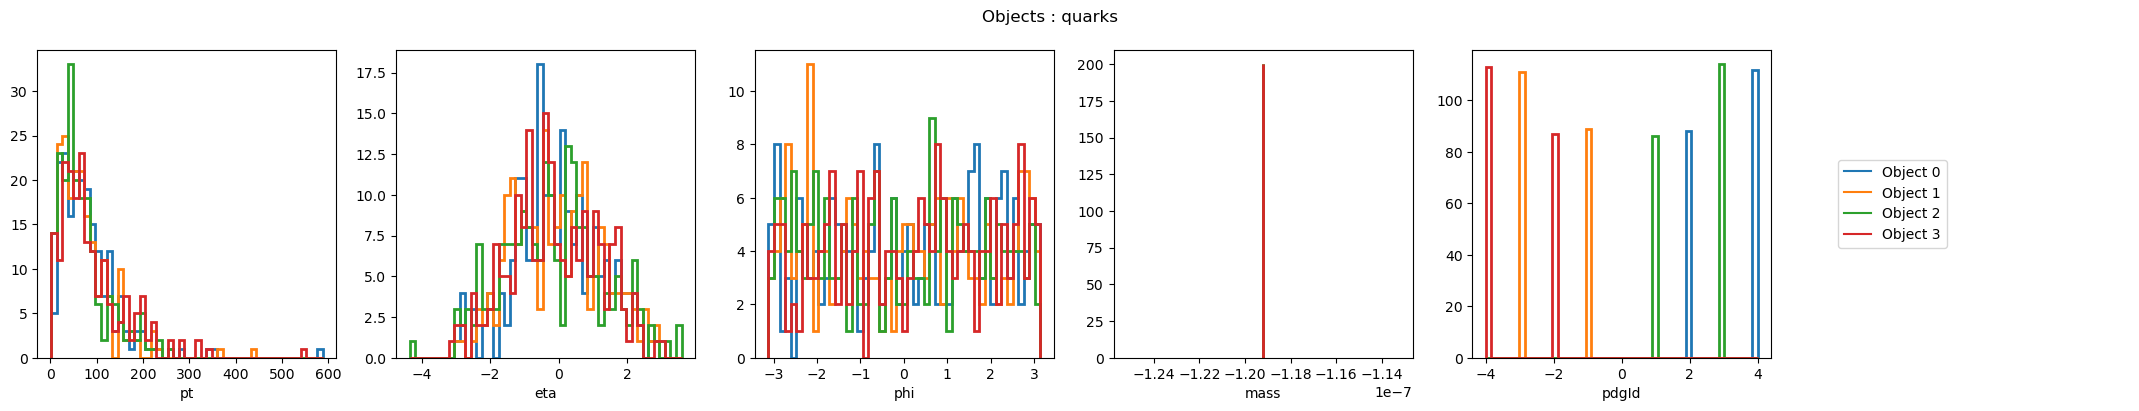

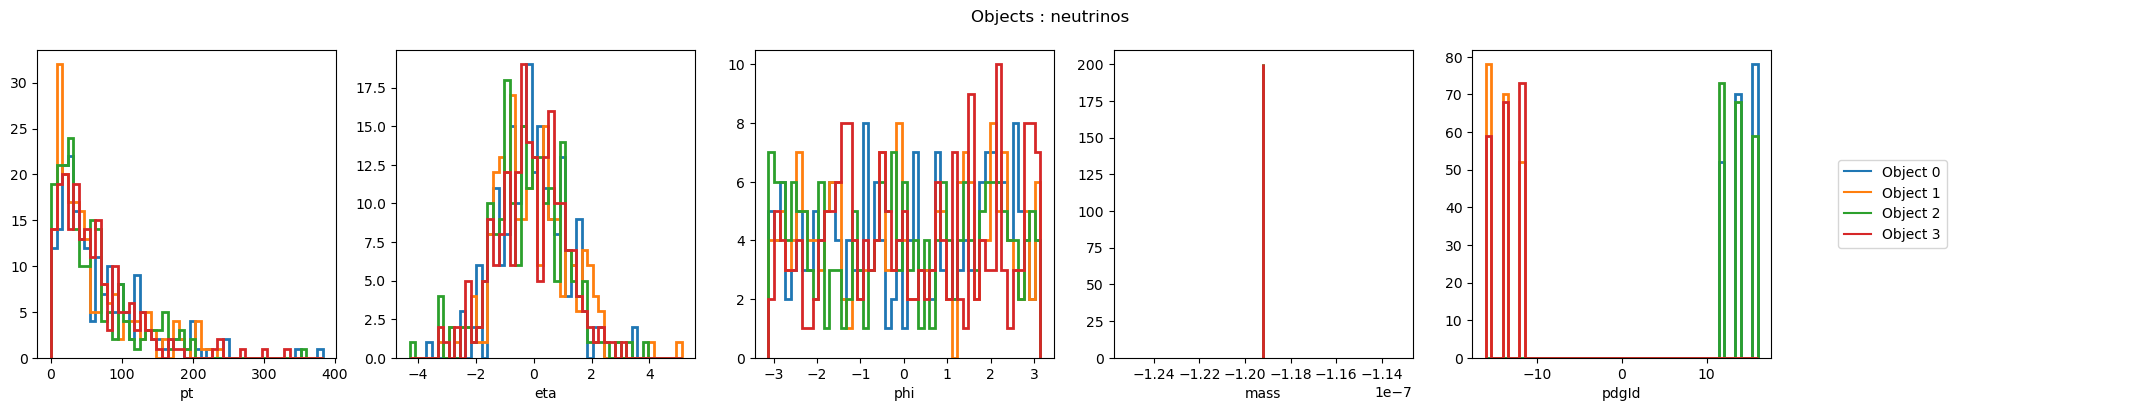

After preprocessing


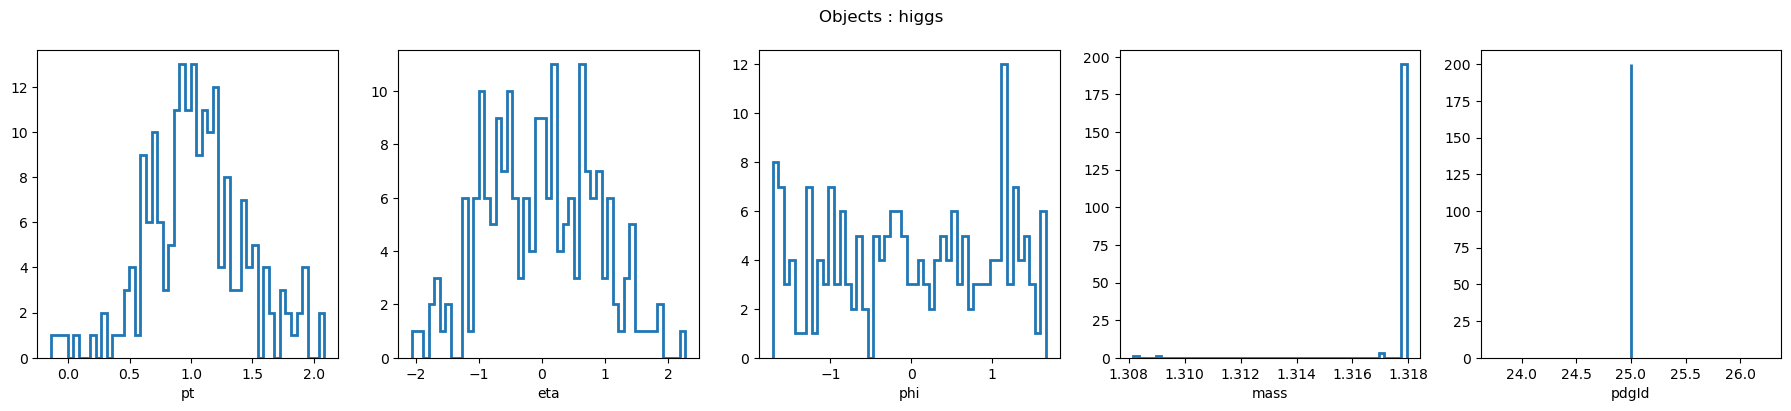

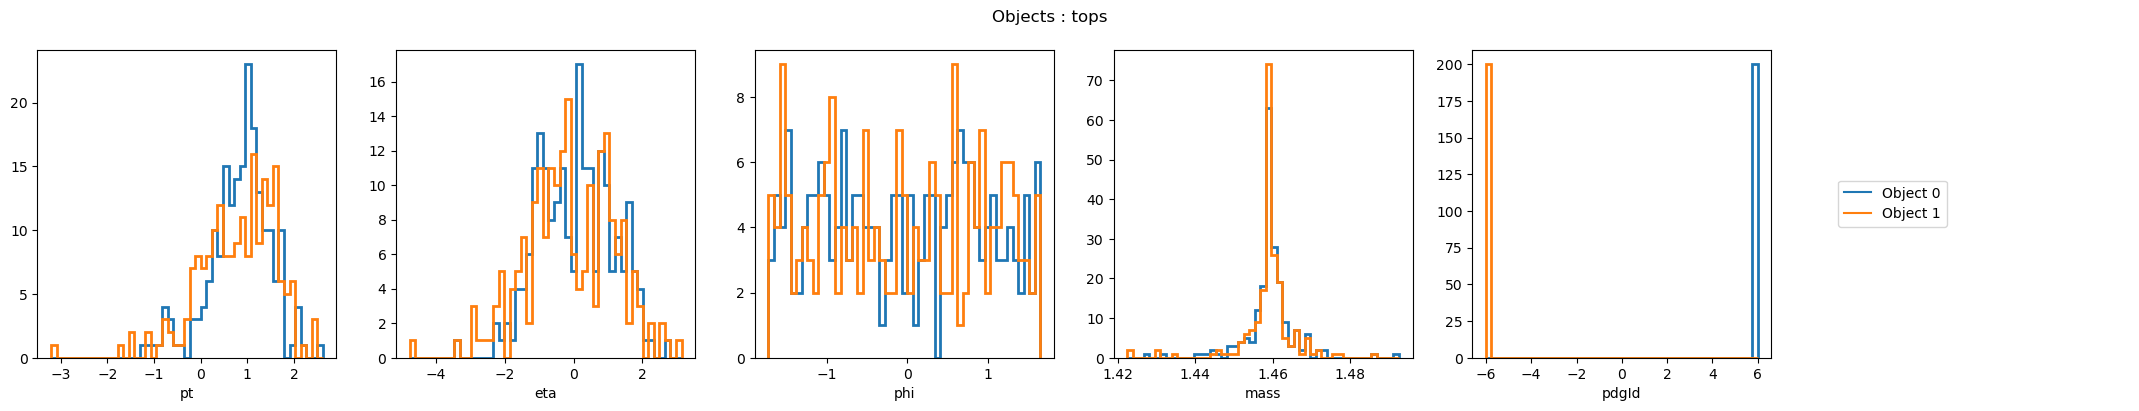

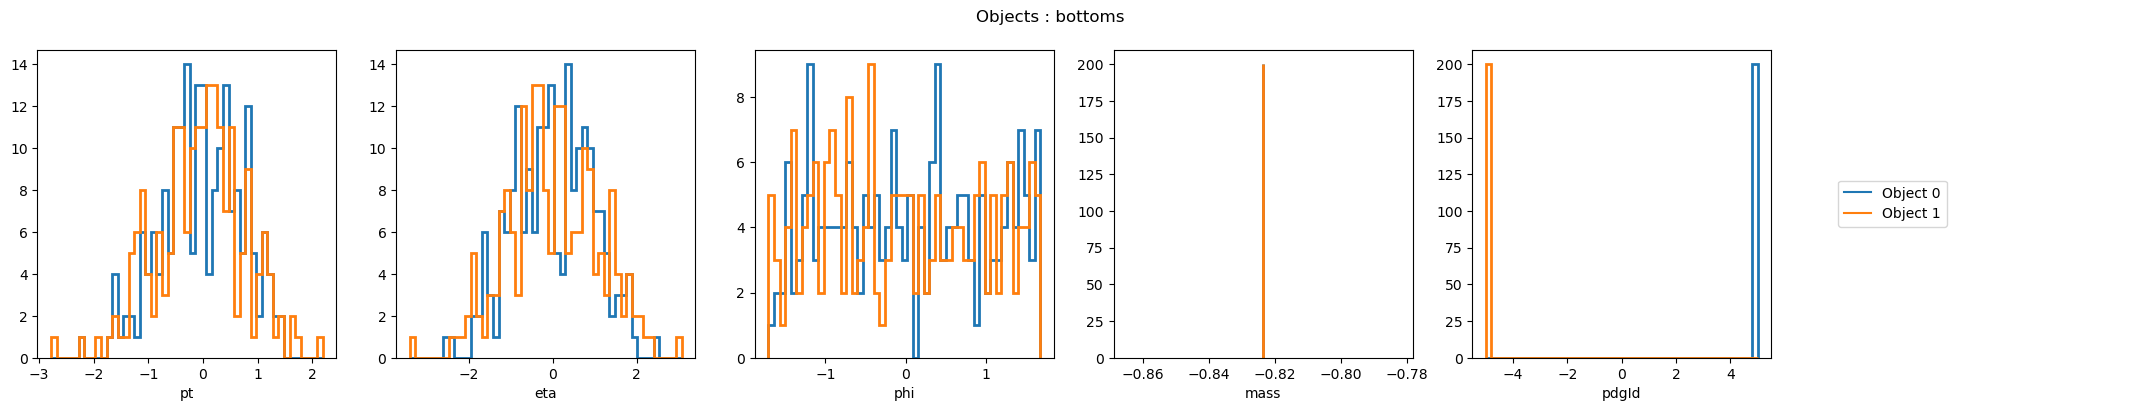

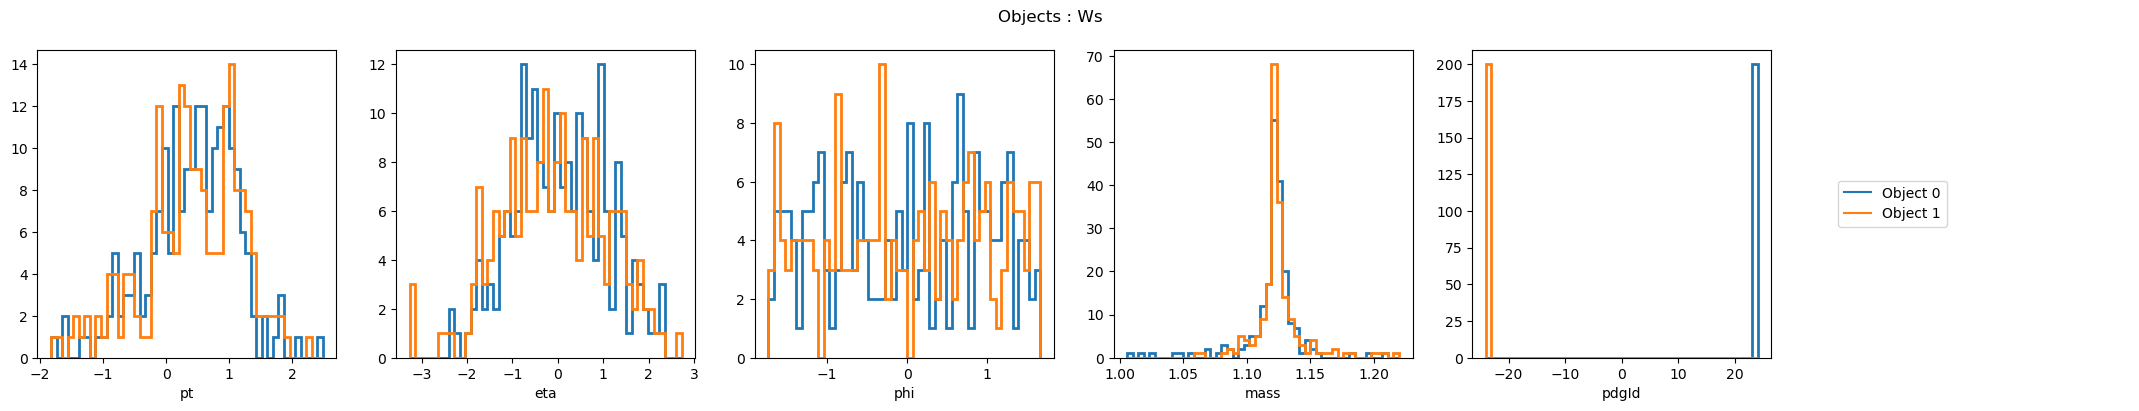

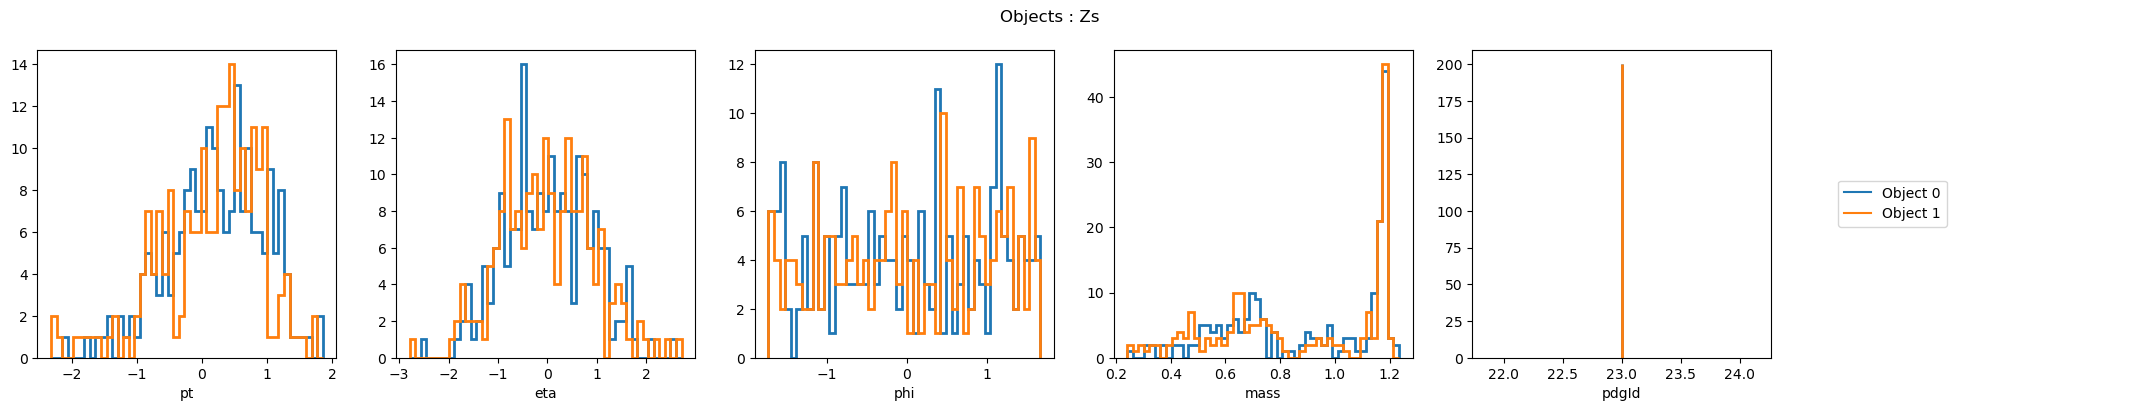

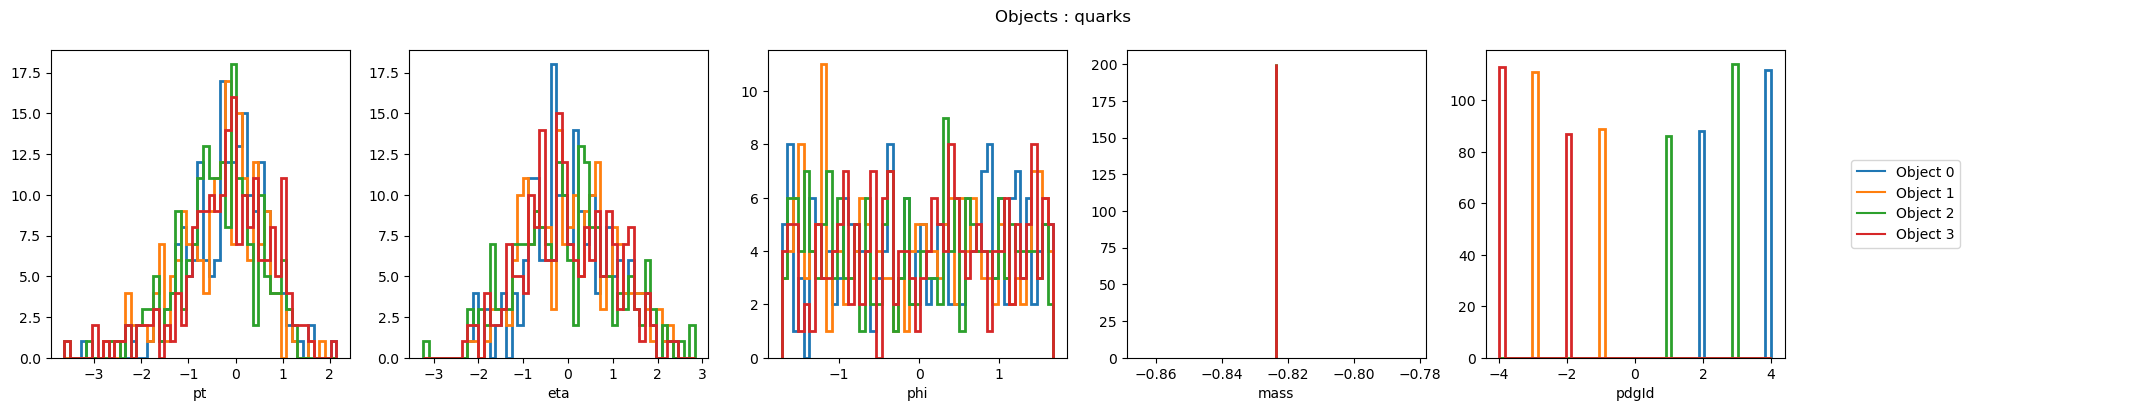

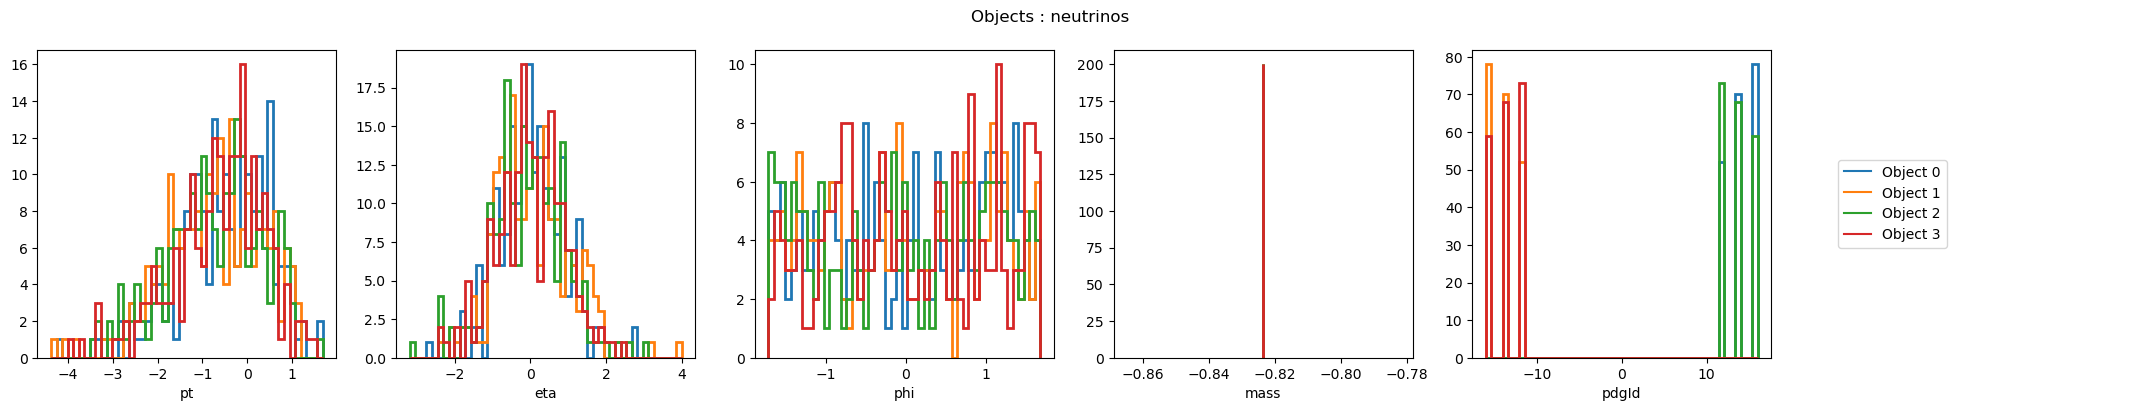

In [28]:
print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False)

In [29]:
# This is not strictly necessary, but just to make sure loading works as expected
# We will use later a combined dataset (hard+reco) below
hard_loader = DataLoader(
    hard_dataset,
    batch_size = 32,
)
batch = next(iter(hard_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],hard_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

higgs torch.Size([32, 1, 5]) torch.Size([32, 1])
tops torch.Size([32, 2, 5]) torch.Size([32, 2])
bottoms torch.Size([32, 2, 5]) torch.Size([32, 2])
Ws torch.Size([32, 2, 5]) torch.Size([32, 2])
Zs torch.Size([32, 2, 5]) torch.Size([32, 2])
quarks torch.Size([32, 4, 5]) torch.Size([32, 4])
neutrinos torch.Size([32, 4, 5]) torch.Size([32, 4])


# Reco dataset

In [30]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    N = data_hard.N,
)

print (data_reco)

Data object
Loaded branches:
   ... file: 500
   ... sample: 500
   ... tree: 500
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


In [31]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = True,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Before cut 500
After cut 258
Saving objects to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 258 events
Containing the following tensors
jets  : data ([258, 12, 5]), mask ([258, 12])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%]
        Mask attn     : [True, True, True, True, True, True, True, True, True, True, True, True]
        Weights       : 258.00, 258.00, 258.00, 258.00, 258.00, 258.00, 258.00, 258.00, 258.00, 258.00, 258.00, 258.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected for batches : True
met   : data ([258, 1, 4]), mask ([25

Before preprocessing


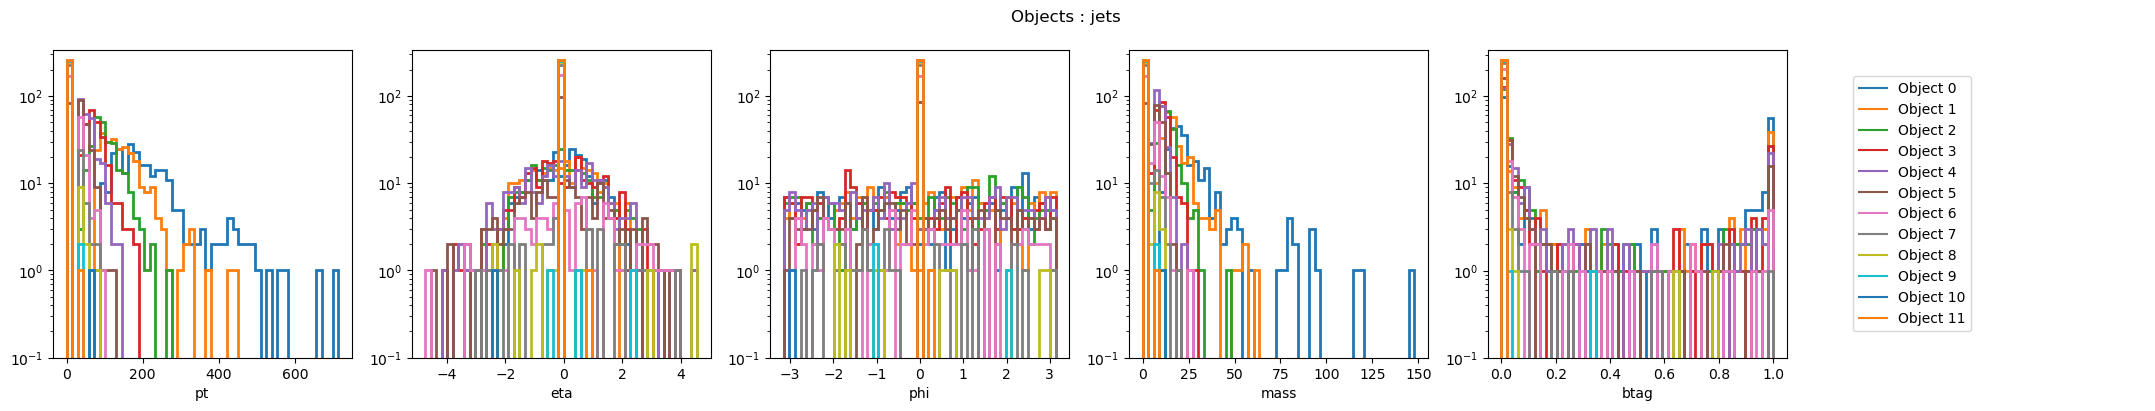

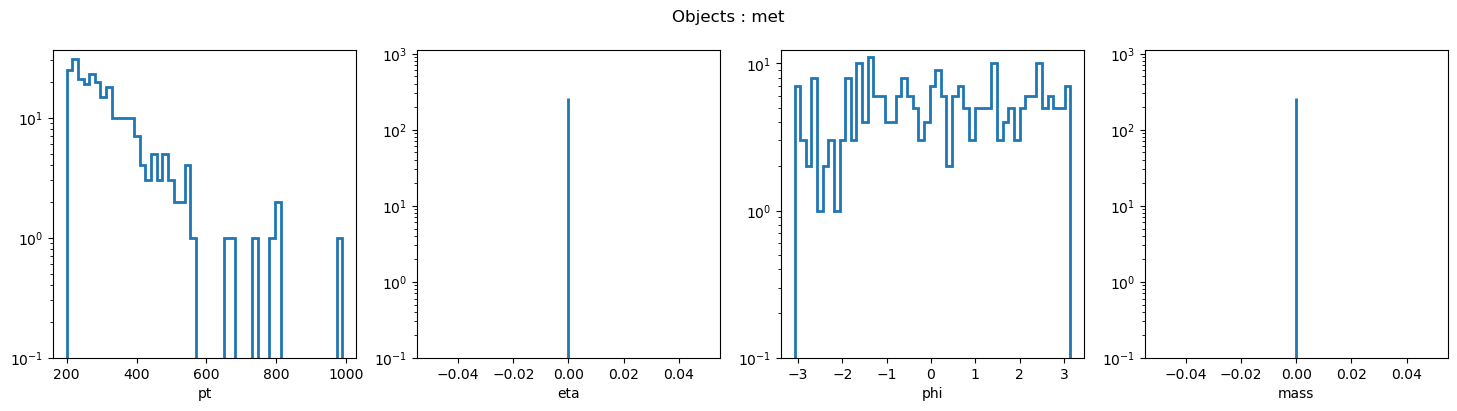

After preprocessing


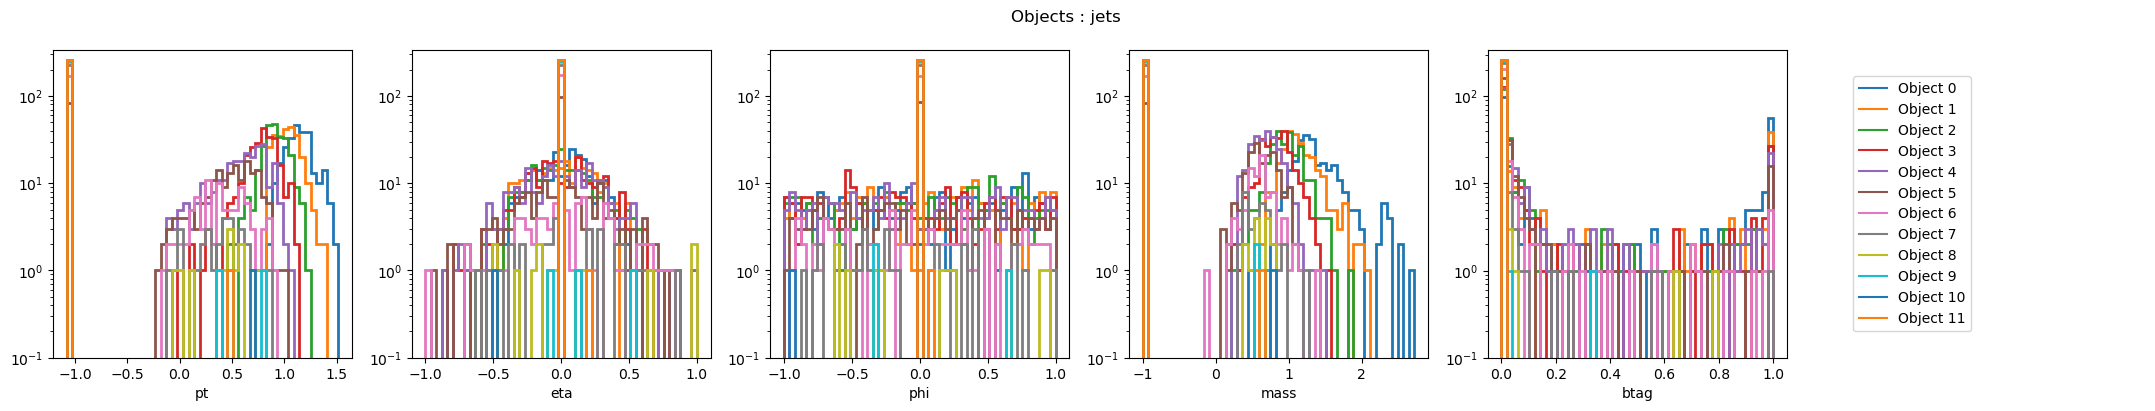

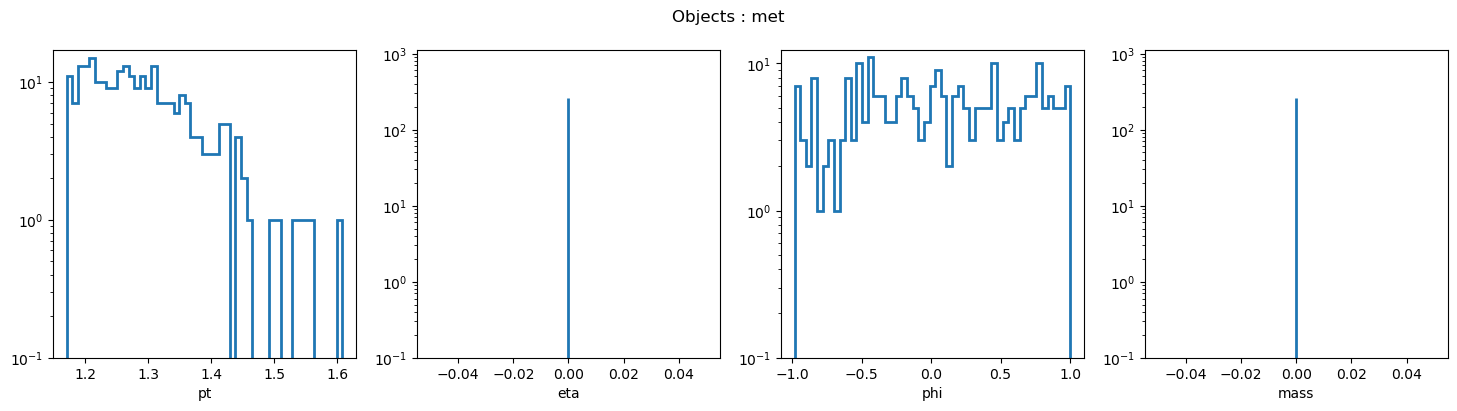

In [32]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [33]:
# Also not needed, just checking 
reco_loader = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(reco_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],reco_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

jets torch.Size([32, 12, 5]) torch.Size([32, 12])
met torch.Size([32, 1, 4]) torch.Size([32, 1])


# Combined dataset

In [34]:
print(reco_dataset.intersection_branch)
print (hard_dataset.metadata.keys())
print (reco_dataset.metadata.keys())

combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print (combined_dataset)

event
dict_keys(['file', 'tree', 'sample', 'intersection'])
dict_keys(['file', 'tree', 'sample', 'intersection'])
Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 200 events, 29 selected
For entry 1 : from 258 events, 29 selected
Combined dataset (extracting 29 events of the following) :
Parton dataset with 200 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
boost      : data ([200, 1, 4]), mask ([200, 1])
             Mask exist    : [100.00%]
             Mask attn     : [True]
             Weights       : 200.00
             Features      : ['x', 'y', 'z', 't']
  

In [35]:
combined_loader = DataLoader(
    combined_dataset,
    batch_size = 256,
)
batch = next(iter(combined_loader))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],combined_loader.dataset.reco_dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Hard')
for obj,mask,sel in zip(batch['hard']['data'],batch['hard']['mask'],combined_loader.dataset.hard_dataset.selection):
    print (sel,obj.shape,mask.shape)

Reco
jets torch.Size([29, 12, 5]) torch.Size([29, 12])
met torch.Size([29, 1, 4]) torch.Size([29, 1])
Hard
higgs torch.Size([29, 1, 5]) torch.Size([29, 1])
tops torch.Size([29, 2, 5]) torch.Size([29, 2])
bottoms torch.Size([29, 2, 5]) torch.Size([29, 2])
Ws torch.Size([29, 2, 5]) torch.Size([29, 2])
Zs torch.Size([29, 2, 5]) torch.Size([29, 2])
quarks torch.Size([29, 4, 5]) torch.Size([29, 4])
neutrinos torch.Size([29, 4, 5]) torch.Size([29, 4])


In [36]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(combined_dataset))
sep = int(train_frac*len(combined_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

combined_dataset_train = torch.utils.data.Subset(combined_dataset,train_indices)
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
print (f'Dataset : training {len(combined_dataset_train)} / validation {len(combined_dataset_valid)}')

batch_size = 1024

combined_loader_train = DataLoader(
    combined_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
combined_loader_valid = DataLoader(
    combined_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)
print (f'Batching {len(combined_loader_train)} / Validation {len(combined_loader_valid)}')

Dataset : training 23 / validation 6
Batching 1 / Validation 1


In [37]:
# # Find some indices in the validation set with max number of jets
# # To use in the sampling to see a maximum number of jets
# count = ak.count(data_reco['jets'].pt,axis=1).to_numpy()
# mask_max = count == ak.max(count)
# mask_valid = np.full(len(count),fill_value=False)
# mask_valid[valid_indices] = True
# idx_max = np.where(
#     np.logical_and(mask_max,mask_valid)
# )[0]
# for i in idx_max:
#     prov = data_reco['jets'].prov[i]
#     unique, counts = np.unique(prov, return_counts=True)
#     print ('idx',i,', '.join([f'prov {u:.0f} x {c:.0f}' for u,c in zip(unique, counts)]))

# Transfer flow

In [38]:
print(combined_dataset.reco_dataset.input_features) # Determine the available features that you can select in ` flow_input_features`
# Note the length of this (2 elements) must match the length of  `flow_input_features`
# But you dont have to select all the features in each element

(('pt', 'eta', 'phi', 'mass', 'btag'), ('pt', 'eta', 'phi', 'mass'))


In [39]:
# Transfer flow #
model = TransferFlow(
    # General args #
    dropout = 0.,
    # Embedding arguments #
    embed_dims = [32,64],
    embed_act = nn.GELU,
    # Particle features, names, masks, and number for printouts and logging #
    n_hard_particles_per_type = combined_dataset.hard_dataset.number_particles_per_type,
    hard_particle_type_names = combined_dataset.hard_dataset.selection,
    hard_input_features_per_type = combined_dataset.hard_dataset.input_features,
    n_reco_particles_per_type = combined_dataset.reco_dataset.number_particles_per_type,
    reco_particle_type_names = combined_dataset.reco_dataset.selection,
    reco_input_features_per_type = combined_dataset.reco_dataset.input_features,
    flow_input_features = [ # features to be used in the flows (different from the tranformer)
        # ['pt','eta','phi'], # leptons
        ['pt','eta','phi'], # jets
        ['pt','phi'],        # met

    ],
    hard_mask_attn = None,
    reco_mask_attn = combined_dataset.reco_dataset.attention_mask,
    # Transformer arguments #
    onehot_encoding = False, # add onehot encoded position vector to particles
    transformer_args = { # to be passed to the Transformer pytorch class
        'nhead' : 8,
        'num_encoder_layers' : 8, 
        'num_decoder_layers' : 8, 
        'dim_feedforward' : 128, 
        'activation' : 'gelu', 
    },
    # Flow args #
    flow_common_args = { # common args for all flows
        'bins' : 16,
        'transforms' : 5,
        'randperm' : True,
        'passes' : None,
        'hidden_features' : [128] * 2,   
    },
    flow_classes = { # classes for each feature
        'pt'  : zuko.flows.NSF,
        'eta' : UniformNSF,
        'phi' : UniformNCSF,
    },
    flow_specific_args = { # specific args for each class above
        'eta' : {'bound' : 1.},
        'phi' : {'bound' : 1.},
    },
    flow_mode = 'global', # 'global', 'type' or 'particle'
)
model = model.cpu()

# Just check the model before training #
batch = next(iter(combined_loader_train))

log_probs, mask, weights = model(batch)
mask = mask > 0
print ('log_probs',log_probs,log_probs.shape)
print ('mask',mask,mask.shape)
print ('weights',weights,weights.shape)

log_probs_tot = model.shared_eval(batch,0,'test')
print ('tot log probs',log_probs_tot)

samples = model.sample(batch['hard']['data'],batch['hard']['mask'],batch['reco']['data'],batch['reco']['mask'],N=100)
print ('samples')
for sample in samples:
    print ('\t',sample.shape)

print (model)

No hard attention mask provided, will use the exist mask for the attention


log_probs tensor([[4.3466, 2.0138, 3.4647, 1.8613, 3.8742, 3.0323, 3.0780, 3.0771, 3.0800,
         3.0857, 3.0933, 3.1011, 2.9299],
        [4.0327, 4.0704, 3.1248, 3.6921, 2.0056, 3.3038, 2.7571, 2.3734, 2.4112,
         2.4108, 2.4111, 2.4111, 2.9881],
        [4.0418, 3.3247, 3.1880, 3.5143, 3.7068, 1.7927, 2.2072, 2.6382, 2.7398,
         2.7858, 2.7885, 2.7883, 2.3096],
        [3.9907, 3.7874, 3.6067, 3.1309, 2.5568, 2.6747, 2.5210, 2.5768, 2.5646,
         2.5542, 2.5442, 2.5404, 2.8906],
        [3.2576, 3.7471, 3.0435, 3.1171, 1.7583, 3.4212, 3.4094, 3.4125, 3.4170,
         3.4207, 3.4231, 3.4256, 2.5379],
        [3.1564, 2.9610, 3.4190, 3.0322, 3.3566, 2.8690, 2.7508, 2.7770, 2.7661,
         2.7576, 2.7515, 2.7477, 3.3100],
        [3.3921, 2.9241, 2.3117, 2.9291, 3.1564, 3.2890, 2.7390, 2.7835, 2.7724,
         2.7714, 2.7670, 2.7619, 2.7140],
        [3.5622, 3.7012, 3.4488, 2.7359, 2.6480, 3.6059, 3.6089, 3.6131, 3.6178,
         3.6229, 3.6281, 3.6327, 2.8611],
      

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [66]:
# # Preprocess the dataset to include only the first 2 jets
# print(combined_dataset_valid.keys())
# print(type(combined_dataset_valid['reco']))
# print(combined_dataset_valid['reco'])
# # Limit to the first 2 jets in the 'data' key
# for i, tensor in enumerate(combined_dataset_valid['reco']['data']):
#     combined_dataset_valid['reco']['data'][i] = tensor[:2]  # Keep only the first 2 jets
# print(combined_dataset_valid['reco']['data'])

# Callbacks to make plots within comet
bias = BiasCallback(
    dataset = combined_dataset_valid,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100,                                 # number of samples to draw
    frequency = 20,                                 # plotting frequency (epochs)
    raw = True,
    bins = 101,                                      # 1D/2D plot number of bins
    points = 20,                                    # Number of points for the quantile
    log_scale = True,                               # log
    batch_size = 50000,                              # Batch size to evaluate the dataset (internally makes a loaded)
    N_batch = 1,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                                 # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)
figs = bias.make_bias_plots(model.cuda(),show=True) # show is to plot standalone 
# of course now they are bad, need to train first

dict_keys(['hard', 'reco'])
<class 'dict'>
{'data': [tensor([[ 1.3970,  0.0762,  0.7580,  2.3598,  0.7012],
        [ 1.2089, -0.0081, -0.4890,  1.9968,  0.0138]]), tensor([[ 1.2007,  0.0000, -0.0297,  0.0000]])], 'mask': [tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), tensor([1.])], 'weights': [tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), tensor([1.])]}
[tensor([[ 1.3970,  0.0762,  0.7580,  2.3598,  0.7012],
        [ 1.2089, -0.0081, -0.4890,  1.9968,  0.0138]]), tensor([[ 1.2007,  0.0000, -0.0297,  0.0000]])]


Predict:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0

In [41]:
idx_to_monitor = [0,1,2]
sampling = SamplingCallback(
    dataset = combined_dataset_valid[:1],           # dataset to check sampling
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline
    idx_to_monitor = [0,1,2,3,4],               # idx of events in dataset to make plots with
    N_sample = 100000,                         # number of samples to draw
    frequency = 10,                             # plotting frequency (epochs)
    bins = 51,                                  # 1D/2D plot number of bins
    log_scale = True,                           # log
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)
figs = sampling.make_sampling_plots(model.cuda(),show=True) # show is to plot standalone 

KeyError: tensor(0)

In [ ]:
##### Parameters #####
epochs = 40
steps_per_epoch_train = math.ceil(len(combined_dataset_train)/combined_loader_train.batch_size)

print (f'Training   : Batch size = {combined_loader_train.batch_size} => {steps_per_epoch_train} steps per epoch')
##### Optimizer #####
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.1, 
    patience=10, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=0, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
    bias,
]

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-ttH',
    experiment_name = 'combined',
    offline = False,
) 
logger.log_graph(model)
logger.experiment.log_notebook(filename='transfer_flow_ttH.ipynb',overwrite=True)

##### Trainer #####
trainer = L.Trainer(
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train/100,
)
##### Fit #####
trainer.fit(
    model = model,
    train_dataloaders = combined_loader_train,
    val_dataloaders = combined_loader_valid,
)

Training   : Batch size = 1024 => 1 steps per epoch


CometLogger will be initialized in offline mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | hard_embeddings     | ModuleList         | 2.3 K  | train
1 | hard_embeddings.0   | Sequential         | 2.3 K  | train
2 | reco_embeddings     | ModuleList         | 4.6 K  | train
3 | reco_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/zuko/transforms.py:494: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when conver

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/cephfs/dice/users/sa21722/projects/MEM/memflow/callbacks/transfer_flow_callbacks.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))

Detected KeyboardInterrupt, attempting graceful shutdown ...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : combined
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
CO

NameError: name 'exit' is not defined

In [ ]:
figs = sampling.make_sampling_plots(model.cuda(),show=True) # show is to plot standalone 

In [ ]:
figs = bias.make_bias_plots(model.cuda(),show=True) # show is to plot standalone 